In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Clean and join sales and inventory data

## 1.1. Clean sales data

In [2]:
def concat_sales(sales_paths):

    # Define columns to be used
    sales_usecols = ['CHI NHÁNH', 'KÊNH', 'SITE', 'MÃ KHÁCH', 'MÃ HÀNG', 'MÃ 12', 'SLTT', 'NĂM', 'TUẦN']

    # Create an empty list to store cleaned dfs
    cleaned_sales_dfs = []

    # Iterate through each sales file path
    for sales_path in sales_paths:

        # Read the sales file
        raw_sales_df = pd.read_csv(sales_path, usecols=sales_usecols)

        # Filter the df to get only 1100 branch and CHTT channel
        filtered_sales_df = (
            raw_sales_df.query("`CHI NHÁNH` == 1100 and `KÊNH` == 'CHTT'")
            [['SITE', 'MÃ KHÁCH', 'MÃ HÀNG', 'MÃ 12', 'SLTT', 'NĂM', 'TUẦN']]
            
            # Rename columns
            .rename(columns={
                'SITE': 'store_code',
                'MÃ KHÁCH': 'customer_code',
                'MÃ HÀNG': 'product_code',
                'MÃ 12': 'style_color',
                'SLTT': 'quantity',
                'NĂM': 'year',
                'TUẦN': 'week'
            })
        )

        # Extract the last two digits of week
        filtered_sales_df['week'] = filtered_sales_df['week'].astype(str).str[-2:]

        # Change data types
        filtered_sales_df = filtered_sales_df.astype({
            'store_code': 'int32',
            'quantity': 'int32',
            'year': 'int32',
            'week': 'int32'
        })

        # Append the cleaned df to the list
        cleaned_sales_dfs.append(filtered_sales_df)

    # Concatenate all cleaned dfs into a single df
    concat_df = pd.concat(cleaned_sales_dfs, ignore_index=True)

    return concat_df

def group_sales(concat_df):

    # Group the concatenated sales df by year, week, store code, product code, and style color
    group_df = concat_df.groupby(['year', 'week', 'store_code', 'product_code', 'style_color'], as_index=False)['quantity'].sum()

    return group_df

def combinations_sales(group_df):

    # Get unique values of week, year, store code, and product code
    unique_years = group_df['year'].unique()
    unique_weeks = group_df['week'].unique()
    unique_stores = group_df['store_code'].unique()
    unique_products = group_df['product_code'].unique()

    # Create a multi-index df with all combinations of the unique values
    combinations_df = pd.MultiIndex.from_product([unique_years, unique_weeks, unique_stores, unique_products], 
                                              names=['year', 'week', 'store_code', 'product_code']).to_frame(index=False)

    return combinations_df

def join_sales(group_df, combinations_df):

    # Join the grouped df with the combinations df
    join_df = pd.merge(combinations_df, group_df, 
                       on=['year', 'week', 'store_code', 'product_code'], 
                       how='left')
    
    return join_df

def full_process_sales_data(sales_paths):

    # Clean and concatenate raw sales files
    concat_df = concat_sales(sales_paths)

    # Group the concatenated df by year, week, store code, and product code
    group_df = group_sales(concat_df)

    # Create a full combinations df of week, year, store code, and product code
    combinations_df = combinations_sales(group_df)

    # Join the grouped df with the full combinations df
    join_df = join_sales(group_df, combinations_df)

    return join_df

## 1.2. Clean inventory data

In [3]:
def full_process_inv_data(inv_paths):

    # Create an empty list to store cleaned dfs
    cleaned_inv_dfs = []

    # Iterate through each inventory file path
    for inv_path in inv_paths:

        # Read the inventory file
        df = pd.read_csv(inv_path)

        # Melt the df
        melted_inv_df = df.melt(
            id_vars=['store_code', 'product_code'],
            var_name='year_week',
            value_name='inventory_quantity'
        )

        # Extract year and week from the 'year_week' column
        melted_inv_df['year'] = melted_inv_df['year_week'].str[:4].astype('int32')
        melted_inv_df['week'] = melted_inv_df['year_week'].str[4:].astype('int32')

        # Drop the 'year_week' column and convert 'store_code' to int32
        melted_inv_df = melted_inv_df.astype({'store_code': 'int32'}).drop(columns='year_week')
        
        # Append the cleaned melted df to the list
        cleaned_inv_dfs.append(melted_inv_df)

    # Concatenate all cleaned melted dfs into a single df
    inv_df = pd.concat(cleaned_inv_dfs, ignore_index=True)

    return inv_df

## 1.3. Join sales and inventory data

In [4]:
def join_sales_inventory(sales_paths, inv_paths):

    # Process sales and inventory data
    sales_df = full_process_sales_data(sales_paths)
    inv_df = full_process_inv_data(inv_paths)

    # Handle large dfs joining in chunks to avoid memory issues
    sales_chunk_size = 30000000
    sales_chunks = [sales_df[i:i+sales_chunk_size] for i in range(0, sales_df.shape[0], sales_chunk_size)]

    # Create an empty list to store joined chunks
    join_sales_inv_chunk = []

    # Iterate through each chunk of sales data and merge with inventory data
    for sales_chunk in sales_chunks:
        join_chunk = pd.merge(
            sales_chunk,
            inv_df,
            on=['year', 'week', 'store_code', 'product_code'],
            how='left'
        )

        # Fill NaN values in 'quantity' and 'inventory_quantity' columns
        join_chunk['quantity'] = join_chunk['quantity'].fillna(0).astype('int32')
        join_chunk['inventory_quantity'] = join_chunk['inventory_quantity'].fillna(0).astype('int32')

        # Append the joined chunk to the list
        join_sales_inv_chunk.append(join_chunk)

    # Concatenate all joined chunks into a single df
    sales_inv_df = pd.concat(join_sales_inv_chunk, ignore_index=True)
    
    return sales_inv_df

# 2. Join sales-inventory data with calendar and assortment data

In [5]:
def join_sales_inv_calendar_assortment(sales_inv_df, calendar_df, assortment_df):

    # Convert data types for calendar_df and assortment_df to optimize memory usage
    calendar_df['year'] = calendar_df['year'].astype('int32')
    calendar_df['month'] = calendar_df['month'].astype('int32')
    calendar_df['week'] = calendar_df['week'].astype('int32')
    calendar_df['lunar_new_year'] = calendar_df['lunar_new_year'].astype('int32')
    assortment_df['order_decision'] = assortment_df['order_decision'].astype('int32')
    assortment_df['store_code'] = assortment_df['store_code'].astype('int32')
    assortment_df['assortment'] = assortment_df['assortment'].astype('int32')

    # Join sales-inventory data with calendar and assortment data
    join_sales_inv_calendar_df = pd.merge(
        sales_inv_df, 
        calendar_df, 
        how='left', 
        on=['year', 'week']
        )
    
    join_sales_inv_calendar_assortment_df = pd.merge(
        join_sales_inv_calendar_df, 
        assortment_df,
        how='left',
        on=['season', 'store_code', 'style_color']
        )
    
    # Fill NaN values of order_decision and assortment and convert data types
    join_sales_inv_calendar_assortment_df['order_decision'] = join_sales_inv_calendar_assortment_df['assortment'].fillna(0).astype('int32')
    join_sales_inv_calendar_assortment_df['assortment'] = join_sales_inv_calendar_assortment_df['assortment'].fillna(0).astype('int32')

    # Drop unnecessary columns
    join_sales_inv_calendar_assortment_df = join_sales_inv_calendar_assortment_df.drop(
       columns=['season', 'style_color', 'month', 'lunar_new_year', 'style_color_rank', 'order_decision'])

    return join_sales_inv_calendar_assortment_df


# 3. Calculate corrected sales

In [6]:
def calculate_rolling_average_ignore_zeros(series, window):

    # Calculate rolling average with determine window while ignoring zeros
    return series.rolling(window=window, min_periods=1).apply(
        lambda x: np.mean(x[x > 0]) if np.any(x > 0) else 0,
        raw=True
    )

def calculate_lost_sales(df, avg_col, new_col):

    # Calculate lost sales
    df[new_col] = np.maximum(df[avg_col] - df['quantity'], 0)
    return df

def process_corrected_sales(df):
    
    # Calculate valid sales only when both in stock and in assortment
    df['sales_in_stock_in_assortment'] = (
        df['quantity'] * (df['inventory_quantity'] > 0) * (df['assortment'] > 0)
    )

    # Sort for correct rolling behavior
    df.sort_values(by=['product_code', 'store_code', 'year', 'week'], inplace=True)

    # Group by and apply rolling average
    group_cols = ['product_code', 'store_code']
    sales_col = 'sales_in_stock_in_assortment'

    df['average_4w_sales_in_stock'] = (
        df.groupby(group_cols)[sales_col]
          .transform(lambda x: calculate_rolling_average_ignore_zeros(x, 4))
    )

    df['average_8w_sales_in_stock'] = (
        df.groupby(group_cols)[sales_col]
          .transform(lambda x: calculate_rolling_average_ignore_zeros(x, 8))
    )

    # Calculate lost sales
    df = calculate_lost_sales(df, 'average_4w_sales_in_stock', 'lost_sales_4w')
    df = calculate_lost_sales(df, 'average_8w_sales_in_stock', 'lost_sales_8w')

    # Calculate corrected sales
    df['corrected_sales_4w'] = df['quantity'] + df['lost_sales_4w'] * 0.35
    df['corrected_sales_8w'] = df['quantity'] + df['lost_sales_8w'] * 0.35

    return df

# 4. Run and visualize the final result

In [7]:
# Sales paths
sales_path_1 = "D:\\retail_planning_project\\0. input_data\\sales\\raw_data\\sales_2023.csv"
sales_path_2 = "D:\\retail_planning_project\\0. input_data\\sales\\raw_data\\sales_2024.csv"
sales_paths = (sales_path_1, sales_path_2)

# Inventory paths
inv_path_1 = "D:\\retail_planning_project\\0. input_data\\inventory\\raw_data\\inventory_2023.csv"
inv_path_2 = "D:\\retail_planning_project\\0. input_data\\inventory\\raw_data\\inventory_2024.csv"
inv_paths = (inv_path_1, inv_path_2)

# Calendar df
calendar_df = pd.read_csv("D:\\retail_planning_project\\0. input_data\\calendar\\calendar.csv")

# Assortment df
assortment_df = pd.read_csv("D:\\retail_planning_project\\0. input_data\\assortment\\processed_data\\assortment.csv")

# Process and join sales and inventory data
sales_inv_df = join_sales_inventory(sales_paths, inv_paths)

# Join sales, inventory, calendar, and assortment data
join_sales_inv_calendar_assortment_df = join_sales_inv_calendar_assortment(sales_inv_df, calendar_df, assortment_df)

# Calculate corrected sales data
corrected_sales_df = process_corrected_sales(join_sales_inv_calendar_assortment_df)

C:\Users\thanh\AppData\Local\Temp\ipykernel_1304\3602329557.py:13: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_sales_df = pd.read_csv(sales_path, usecols=sales_usecols)
C:\Users\thanh\AppData\Local\Temp\ipykernel_1304\3602329557.py:13: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_sales_df = pd.read_csv(sales_path, usecols=sales_usecols)


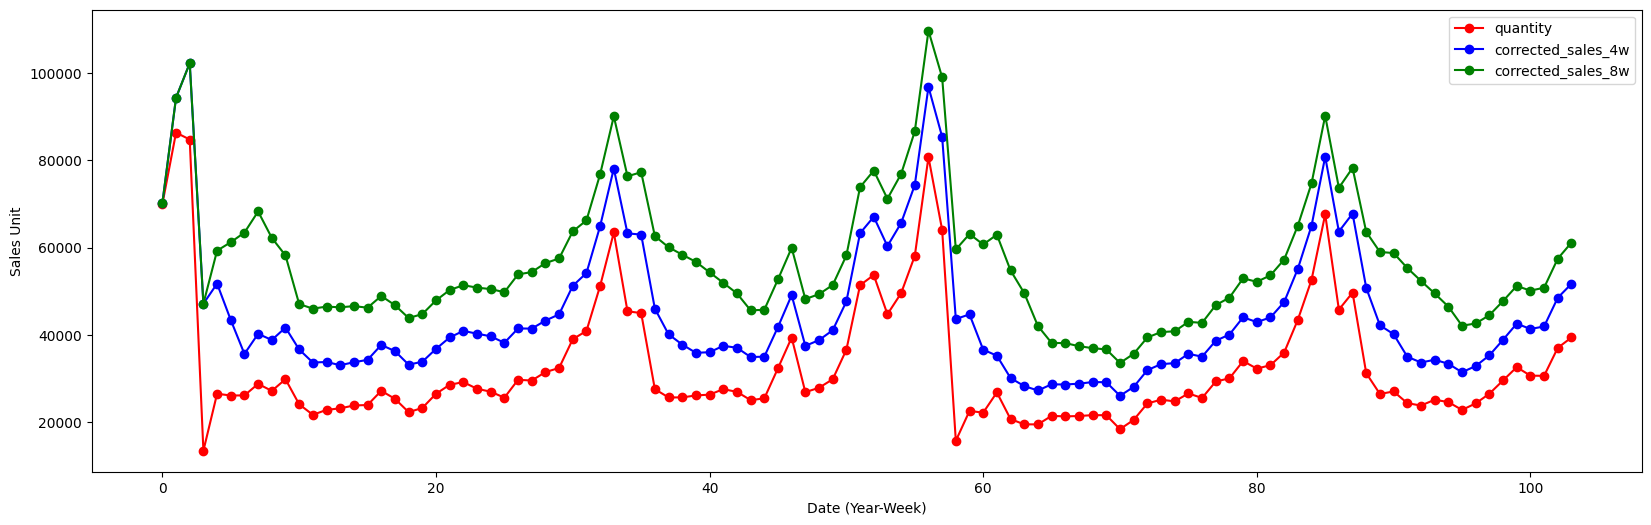

In [8]:
# Group by year and week to plot the data
plot_df = corrected_sales_df.groupby(by=['year', 'week']).agg(quantity=('quantity', 'sum'), 
                                                         corrected_sales_4w=('corrected_sales_4w', 'sum'), 
                                                         corrected_sales_8w=('corrected_sales_8w', 'sum')).reset_index()
plot_df.set_index(['year', 'week'])

# Visualize the actual sales and corrected sales
plt.figure(figsize=(20, 6))
plt.plot(plot_df.index, plot_df['quantity'], marker='o', color = 'red', label='quantity')
plt.plot(plot_df.index, plot_df['corrected_sales_4w'], marker='o', color = 'blue', label='corrected_sales_4w')
plt.plot(plot_df.index, plot_df['corrected_sales_8w'], marker='o', color = 'green', label = 'corrected_sales_8w')
plt.xlabel("Date (Year-Week)")
plt.ylabel("Sales Unit")
plt.legend()
plt.show()